In [1]:
install.packages("idefix")
install.packages("mlogit")
install.packages("MASS")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘zoo’, ‘sandwich’, ‘rbibutils’, ‘mvtnorm’, ‘gmm’, ‘Formula’, ‘jpeg’, ‘png’, ‘webshot’, ‘Rdpack’, ‘tmvtnorm’, ‘dfidx’, ‘shinyjs’, ‘tableHTML’, ‘RcppArmadillo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘lmtest’, ‘statmod’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
################################################################
### Analysis of Choice Based Conjoint survey data            ###
### The Multinomial Logit and Mixed Multinomial Logit models ###
################################################################


# load library for fitting multinomial logit models
library(mlogit)

# import the data about the choice_data Survey for conjoint analysis
choice_data <- read.csv("Choice_Data_Converted.csv", sep=";")
head(choice_data)

# see some descriptive statistics
summary(choice_data)
xtabs(choice ~ spec, data=choice_data)
xtabs(choice ~ vel, data=choice_data)
xtabs(choice ~ qual, data=choice_data)
xtabs(choice ~ priv, data=choice_data)
xtabs(choice ~ cost, data=choice_data)

# recode some variables
choice_data$spec <- factor(choice_data$spec, levels=c("Assistente","Codice","Content")) # change order of categories
choice_data$vel <- factor(choice_data$vel, levels=c("Lento","Veloce")) # change order of categories
choice_data$qual <- factor(choice_data$qual, levels=c("Ottimale","Sufficente")) # change order of categories
choice_data$priv <- factor(choice_data$priv, levels=c("Bassa","Alta")) # change order of categories
choice_data$cost <- as.factor(choice_data$cost) # convert the variable as qualitative

# Fitting a choice model with "mlogit" function
# mlogit requires the choice data to be in a special data format created using the
# dfidx() function. You pass your choice data to dfidx, along
# with a few parameters telling it how the data is organized.
# dfidx() accepts data in either a "long" or a "wide" format and you tell it
# which you have using the shape parameter.

library(dfidx)
#choice_data.mlogit <- dfidx(choice_data, idx = list(c("ques", "resp.id"), "alt"))

# 1) Crea l'ID della situazione di scelta (una sola riga extra)
choice_data$choice_id <- with(choice_data, paste(resp.id, ques, sep = "_"))

# 2) QUI la riga che mi chiedi: chiamata a dfidx
choice_data.mlogit <- dfidx(
  choice_data,
  idx    = list(c("choice_id", "resp.id"), "alt"),
  choice = "choice",
  shape  = "long"
)


# The resulting choice_data.mlogit is a "dfidx" class object that can be used to estimate
# a model with mlogit(). The syntax for mlogit uses formula notation
# similarly to other functions for regression models in R.
# However, it requires the use of symbol "|" to distinguish between alternative-specific
# and non-alternative specific variables, see ?Formula

m1 <- mlogit(choice ~ spec + vel + qual + priv + cost, data = choice_data.mlogit)
summary(m1)

# Fit the model without intercept parameters
m2 <- mlogit(choice ~ spec + vel + qual + priv + cost | -1, data = choice_data.mlogit)
summary(m2)

# Test the restriction on the intercepts by comparing the two models
# through a likelihood ratio test
lrtest(m2, m1)

# Fit the model without intercept parameters and with price as a quantitative variable
m3 <- mlogit(choice ~ spec + vel + qual + priv
                      + as.numeric(as.character(cost)) | -1, data = choice_data.mlogit)
summary(m3)
lrtest(m3, m2)

# Compute the willingness to pay
coef(m3)["privAlta"]/(coef(m3)["as.numeric(as.character(cost))"]/1000)

# Simulate preference shares using the "predict.mnl" function
# Define the function
predict.mnl <- function(model, data) {
  # Function for predicting preference shares from a MNL model
  # model: mlogit object returned by mlogit()
  # data: a data frame containing the set of designs for which you want to
  #       predict shares.  Same format at the data used to estimate model.
  data.model <- model.matrix(update(model$formula, 0 ~ .), data = data)[,-1]
  logitUtility <- data.model%*%model$coef
  share <- exp(logitUtility)/sum(exp(logitUtility))
  cbind(share, data)
}



Loading required package: dfidx



,resp.id,ques,alt,spec,vel,qual,priv,cost,choice
,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>
1,1,1,alt1,Assistente,Lento,Ottimale,Bassa,25,0
2,1,1,alt2,Codice,Lento,Sufficente,Alta,20,0
3,1,1,alt3,Content,Veloce,Ottimale,Bassa,15,1
4,1,2,alt1,Content,Veloce,Ottimale,Bassa,25,0
5,1,2,alt2,Assistente,Veloce,Ottimale,Bassa,20,0
6,1,2,alt3,Codice,Lento,Sufficente,Alta,15,1


    resp.id         ques          alt                spec          
 Min.   :  1   Min.   : 1.0   Length:3150        Length:3150       
 1st Qu.: 27   1st Qu.: 3.0   Class :character   Class :character  
 Median : 53   Median : 5.5   Mode  :character   Mode  :character  
 Mean   : 53   Mean   : 5.5                                        
 3rd Qu.: 79   3rd Qu.: 8.0                                        
 Max.   :105   Max.   :10.0                                        
     vel                qual               priv                cost      
 Length:3150        Length:3150        Length:3150        Min.   :15.00  
 Class :character   Class :character   Class :character   1st Qu.:15.00  
 Mode  :character   Mode  :character   Mode  :character   Median :20.00  
                                                          Mean   :20.33  
                                                          3rd Qu.:25.00  
                                                          Max.   :25.00  
     c

spec
Assistente     Codice    Content 
       336        334        380 

vel
 Lento Veloce 
   483    567 

qual
  Ottimale Sufficente 
       614        436 

priv
 Alta Bassa 
  593   457 

cost
 15  20  25 
347 359 344 


Call:
mlogit(formula = choice ~ spec + vel + qual + priv + cost, data = choice_data.mlogit, 
    method = "nr")

Frequencies of alternatives:choice
   alt1    alt2    alt3 
0.25333 0.33905 0.40762 

nr method
4 iterations, 0h:0m:0s 
g'(-H)^-1g = 0.000829 
successive function values within tolerance limits 

Coefficients :
                  Estimate Std. Error z-value  Pr(>|z|)    
(Intercept):alt2  0.113071   0.105101  1.0758   0.28200    
(Intercept):alt3  0.214545   0.115036  1.8650   0.06218 .  
specCodice        0.029028   0.092289  0.3145   0.75311    
specContent      -0.375779   0.090709 -4.1427 3.433e-05 ***
velVeloce         0.508327   0.082741  6.1436 8.069e-10 ***
qualSufficente   -0.753827   0.082346 -9.1544 < 2.2e-16 ***
privAlta          0.688028   0.099978  6.8818 5.909e-12 ***
cost20           -0.348535   0.089396 -3.8988 9.669e-05 ***
cost25           -0.634709   0.097228 -6.5281 6.662e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Log-Lik


Call:
mlogit(formula = choice ~ spec + vel + qual + priv + cost | -1, 
    data = choice_data.mlogit, method = "nr")

Frequencies of alternatives:choice
   alt1    alt2    alt3 
0.25333 0.33905 0.40762 

nr method
4 iterations, 0h:0m:0s 
g'(-H)^-1g = 0.00017 
successive function values within tolerance limits 

Coefficients :
                Estimate Std. Error z-value  Pr(>|z|)    
specCodice     -0.020648   0.086113 -0.2398    0.8105    
specContent    -0.339403   0.086593 -3.9195 8.872e-05 ***
velVeloce       0.563625   0.071105  7.9266 2.220e-15 ***
qualSufficente -0.735421   0.078304 -9.3919 < 2.2e-16 ***
privAlta        0.779160   0.086575  8.9998 < 2.2e-16 ***
cost20         -0.367800   0.084133 -4.3716 1.233e-05 ***
cost25         -0.687171   0.091505 -7.5096 5.929e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Log-Likelihood: -1067.7

,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,7,-1067.660,NA,NA,NA
2,9,-1065.906,2,3.508096,0.1730719



Call:
mlogit(formula = choice ~ spec + vel + qual + priv + as.numeric(as.character(cost)) | 
    -1, data = choice_data.mlogit, method = "nr")

Frequencies of alternatives:choice
   alt1    alt2    alt3 
0.25333 0.33905 0.40762 

nr method
4 iterations, 0h:0m:0s 
g'(-H)^-1g = 0.00017 
successive function values within tolerance limits 

Coefficients :
                                 Estimate Std. Error z-value  Pr(>|z|)    
specCodice                     -0.0181256  0.0858466 -0.2111    0.8328    
specContent                    -0.3401062  0.0865166 -3.9311 8.456e-05 ***
velVeloce                       0.5649924  0.0710199  7.9554 1.776e-15 ***
qualSufficente                 -0.7323945  0.0778484 -9.4080 < 2.2e-16 ***
privAlta                        0.7796058  0.0866743  8.9947 < 2.2e-16 ***
as.numeric(as.character(cost)) -0.0686749  0.0091748 -7.4852 7.150e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Log-Likelihood: -1067.7

,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,6,-1067.72,NA,NA,NA
2,7,-1067.66,1,0.1201233,0.7289008


privAlta 
-11352.12

spec,vel,qual,priv,cost
<fct>,<fct>,<fct>,<fct>,<fct>
Assistente,Lento,Ottimale,Bassa,15
Codice,Lento,Ottimale,Bassa,15
Content,Lento,Ottimale,Bassa,15
Assistente,Veloce,Ottimale,Bassa,15
Codice,Veloce,Ottimale,Bassa,15
Content,Veloce,Ottimale,Bassa,15
Assistente,Lento,Sufficente,Bassa,15
Codice,Lento,Sufficente,Bassa,15
Content,Lento,Sufficente,Bassa,15


,spec,vel,qual,priv,cost
,<fct>,<fct>,<fct>,<fct>,<fct>
8,Codice,Lento,Sufficente,Bassa,15
1,Assistente,Lento,Ottimale,Bassa,15
3,Content,Lento,Ottimale,Bassa,15
41,Codice,Veloce,Ottimale,Alta,20
49,Assistente,Lento,Ottimale,Bassa,25
26,Codice,Lento,Ottimale,Bassa,20


,share,spec,vel,qual,priv,cost
,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
8,0.07795432,Codice,Lento,Sufficente,Bassa,15
1,0.16511517,Assistente,Lento,Ottimale,Bassa,15
3,0.11751160,Content,Lento,Ottimale,Bassa,15
41,0.44130718,Codice,Veloce,Ottimale,Alta,20
49,0.08308748,Assistente,Lento,Ottimale,Bassa,25
26,0.11502425,Codice,Lento,Ottimale,Bassa,20


,share,spec,vel,qual,priv,cost
,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
8,0.07877976,Codice,Lento,Sufficente,Bassa,15
1,0.16779210,Assistente,Lento,Ottimale,Bassa,15
3,0.11950074,Content,Lento,Ottimale,Bassa,15
41,0.43574729,Codice,Veloce,Ottimale,Alta,20
49,0.08439891,Assistente,Lento,Ottimale,Bassa,25
26,0.11378120,Codice,Lento,Ottimale,Bassa,20


,level,share,increase
,<chr>,<dbl>,<dbl>
spec1,Assistente,0.08029136,0.001511593
spec2,Codice,0.07877976,0.000000000
spec3,Content,0.05853578,-0.020243980
vel1,Lento,0.07877976,0.000000000
vel2,Veloce,0.13062794,0.051848176
qual1,Ottimale,0.15140528,0.072625518
qual2,Sufficente,0.07877976,0.000000000
priv1,Bassa,0.07877976,0.000000000
priv2,Alta,0.15711100,0.078331233


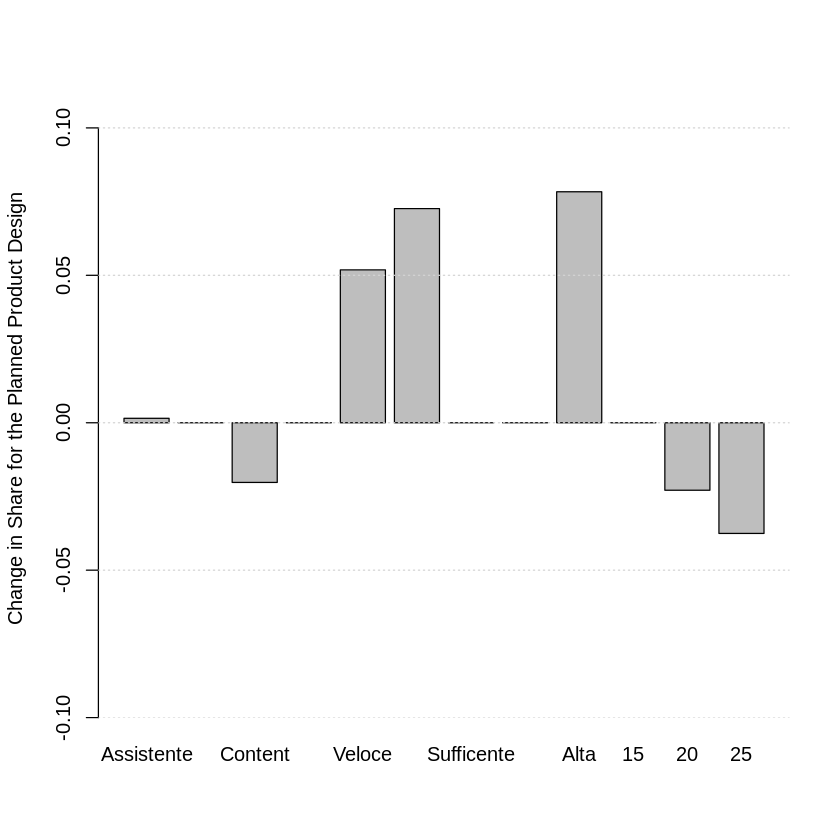

In [3]:
# In order to use "predict.mnl", you need to define a data frame containing the set of designs
# for which you want to predict the preference shares.
# One way to do this is to create the full set of possible designs
# using expand.grid() and select the designs we want by row number
attributes <- list(spec=names(table(choice_data.mlogit$spec)),
               vel=names(table(choice_data.mlogit$vel)),
               qual=names(table(choice_data.mlogit$qual)),
               priv=names(table(choice_data.mlogit$priv)),
               cost=names(table(choice_data.mlogit$cost)))

allDesign <- expand.grid(attributes)
allDesign #all possible design

# we choose a reasonable and realistic subset (where the first row indicates our design), such as
new.data <- allDesign[c(8, 1, 3, 41, 49, 26), ]
new.data

# We then pass these designs to predict.mnl() to determine what customers
# would choose if they had to pick among these six choice_data alternatives:
predict.mnl(m3, new.data) # using m3 specification
predict.mnl(m2, new.data) # using m2 specification

# Compute and plot preference share sensitivity
# Producing a sensitivity chart using R is relatively simple: we just need to loop through all
# the attribute levels, compute a preference share prediction, and save the predicted preference share for
# the target design. The "sensitivity.mnl" function does that.
sensitivity.mnl <- function(model, attrib, base.data, competitor.data) {
  # Function for creating data for a preference share-sensitivity chart
  # model: mlogit object returned by mlogit() function
  # attrib: list of vectors with attribute levels to be used in sensitivity
  # base.data: data frame containing baseline design of target product
  # competitor.data: data frame contining design of competitive set
  data <- rbind(base.data, competitor.data)
  base.share <- predict.mnl(model, data)[1,1]
  share <- NULL
  for (a in seq_along(attrib)) {
    for (i in attrib[[a]]) {
      data[1,] <- base.data
      data[1,a] <- i
      share <- c(share, predict.mnl(model, data)[1,1])
    }
  }
  data.frame(level=unlist(attrib), share=share, increase=share-base.share)
}
base.data <- new.data[1,]
competitor.data <- new.data[-1,]
(tradeoff <- sensitivity.mnl(m2, attributes, base.data, competitor.data))

barplot(tradeoff$increase, horiz=FALSE, names.arg=tradeoff$level,
        ylab="Change in Share for the Planned Product Design",
        ylim=c(-0.1,0.11))
grid(nx=NA, ny=NULL)

specCodice    specContent      velVeloce qualSufficente       privAlta 
           "n"            "n"            "n"            "n"            "n" 
        cost20         cost25 
           "n"            "n"


Call:
mlogit(formula = choice ~ spec + vel + qual + priv + cost | -1, 
    data = choice_data.mlogit, rpar = m2.rpar, correlation = FALSE, 
    panel = TRUE)

Frequencies of alternatives:choice
   alt1    alt2    alt3 
0.25333 0.33905 0.40762 

bfgs method
20 iterations, 0h:0m:4s 
g'(-H)^-1g = 4.91E-07 
gradient close to zero 

Coefficients :
                    Estimate Std. Error z-value  Pr(>|z|)    
specCodice        -0.1614851  0.1190757 -1.3562    0.1750    
specContent       -0.6243106  0.1220063 -5.1170 3.104e-07 ***
velVeloce          0.8266311  0.1000325  8.2636 2.220e-16 ***
qualSufficente    -1.1357993  0.1178959 -9.6339 < 2.2e-16 ***
privAlta           1.3039591  0.1343652  9.7046 < 2.2e-16 ***
cost20            -0.5001723  0.1169565 -4.2766 1.898e-05 ***
cost25            -0.8958841  0.1289142 -6.9495 3.667e-12 ***
sd.specCodice      1.4912631  0.1725296  8.6435 < 2.2e-16 ***
sd.specContent     1.4687761  0.1775902  8.2706 2.220e-16 ***
sd.velVeloce      -0.1020643  0.15

Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
      -Inf -1.1673268 -0.1614851 -0.1614851  0.8443566        Inf

[1] -0.1614851

[1] -0.1614851

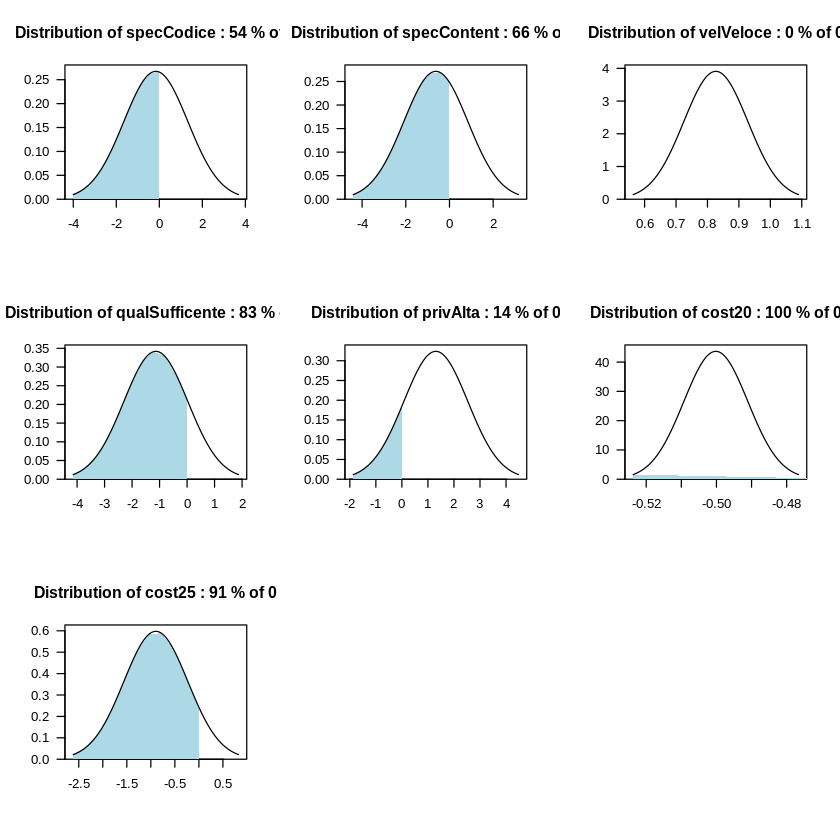


Call:
mlogit(formula = choice ~ spec + vel + qual + priv + cost | -1, 
    data = choice_data.mlogit, rpar = m2.rpar, correlation = TRUE, 
    panel = TRUE)

Frequencies of alternatives:choice
   alt1    alt2    alt3 
0.25333 0.33905 0.40762 

bfgs method
42 iterations, 0h:0m:8s 
g'(-H)^-1g = 3.17E-07 
gradient close to zero 

Coefficients :
                                    Estimate Std. Error z-value  Pr(>|z|)    
specCodice                          0.031712   0.133391  0.2377 0.8120869    
specContent                        -0.434601   0.125587 -3.4605 0.0005391 ***
velVeloce                           0.951805   0.108622  8.7626 < 2.2e-16 ***
qualSufficente                     -1.079111   0.129065 -8.3610 < 2.2e-16 ***
privAlta                            1.515353   0.148768 10.1860 < 2.2e-16 ***
cost20                             -0.247453   0.143139 -1.7288 0.0838530 .  
cost25                             -0.733394   0.154089 -4.7596 1.940e-06 ***
chol.specCodice:specCodice     

,specCodice,specContent,velVeloce,qualSufficente,privAlta,cost20,cost25
specCodice,1.00000000,0.45067147,0.33987308,-0.54731928,0.1942269,-0.20291508,-0.05431843
specContent,0.45067147,1.00000000,0.98918134,0.03101642,0.3999823,0.05761768,0.24627178
velVeloce,0.33987308,0.98918134,1.00000000,0.10080838,0.4382386,0.08121885,0.26740846
qualSufficente,-0.54731928,0.03101642,0.10080838,1.00000000,-0.2407235,0.42868150,0.44684331
privAlta,0.19422694,0.39998228,0.43823859,-0.24072349,1.0000000,0.34677979,0.24222677
cost20,-0.20291508,0.05761768,0.08121885,0.42868150,0.3467798,1.00000000,0.89520551
cost25,-0.05431843,0.24627178,0.26740846,0.44684331,0.2422268,0.89520551,1.00000000


                                Estimate Std. Error z-value  Pr(>|z|)    
sd.specCodice                   1.882091   0.216974  8.6743 < 2.2e-16 ***
sd.specContent                  1.667396   0.206186  8.0868 6.123e-16 ***
sd.velVeloce                    0.325650   0.163118  1.9964 0.0458891 *  
sd.qualSufficente               2.001199   0.205512  9.7376 < 2.2e-16 ***
sd.privAlta                     1.763713   0.188113  9.3758 < 2.2e-16 ***
sd.cost20                       0.730738   0.168920  4.3259 1.519e-05 ***
sd.cost25                       1.788242   0.215469  8.2993 < 2.2e-16 ***
cor.specCodice:specContent      0.450671   0.120357  3.7445 0.0001808 ***
cor.specCodice:velVeloce        0.339873   0.755755  0.4497 0.6529172    
cor.specContent:velVeloce       0.989181   0.692049  1.4294 0.1529033    
cor.specCodice:qualSufficente  -0.547319   0.284525 -1.9236 0.0544014 .  
cor.specContent:qualSufficente  0.031016   0.194956  0.1591 0.8735942    
cor.velVeloce:qualSufficente    0.1008

,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,7,-1067.6603,NA,NA,NA
2,14,-948.3654,7,238.5898,7.412612e-48


,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,14,-948.3654,NA,NA,NA
2,35,-898.9953,21,98.74017,4.817147e-12


,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,17,-934.6156,NA,NA,NA
2,35,-898.9953,18,71.24067,2.783897e-08


,colMeans(shares),spec,vel,qual,priv,cost
,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
8,0.06386471,Codice,Lento,Sufficente,Bassa,15
1,0.13984490,Assistente,Lento,Ottimale,Bassa,15
3,0.06705146,Content,Lento,Ottimale,Bassa,15
41,0.58321947,Codice,Veloce,Ottimale,Alta,20
49,0.08410361,Assistente,Lento,Ottimale,Bassa,25
26,0.06191585,Codice,Lento,Ottimale,Bassa,20


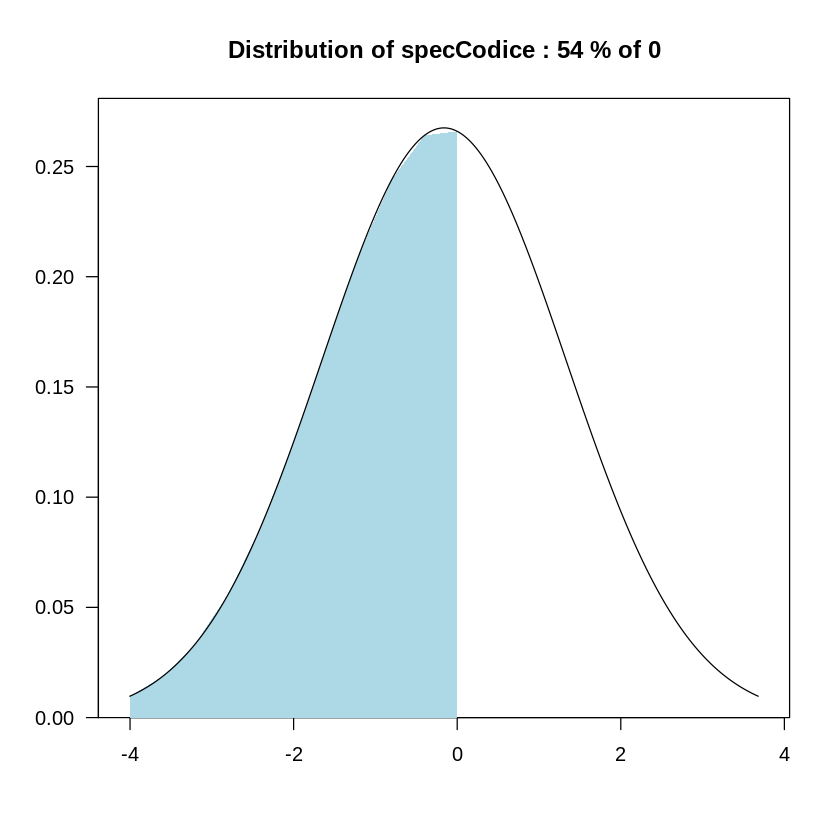

In [5]:


#######################

### Controlling for consumer heterogeneity

# Fit a mixed MNL model
# The statistical term for coefficients that vary across respondents (or customers) is
# random coefficients or random effects. To estimate a multinomial
# logit model with random coefficients using "mlogit", we define a vector indicating
# which coefficients should vary across customers. "mlogit" requires a character
# vector the same length as the coefficient vector with a letter code indicating what
# distribution the random coefficients should follow across the respondents: "n" for
# normal, "l" for log normal, "t" for truncated normal, and "u" for uniform. For this
# analysis, we assume that all the coefficients are normally distributed across the population
# and call our vector "m2.rpar".

m2.rpar <- rep("n", length=length(m2$coef))
names(m2.rpar) <- names(m2$coef)
m2.rpar

# We pass this vector to mlogit as the rpar parameter, which is short for "random
# parameters". In addition, we tell mlogit that we have multiple choice observations
# for each respondent (panel=TRUE) and whether we want to allow the random
# parameters to be correlated with each other. For this first run, we assume that we do
# not want random parameters to be correlated (correlation=FALSE), a setting
# we reconsider below.
m2.mixed <- mlogit(choice ~ spec + vel + qual + priv + cost | -1,
                  data = choice_data.mlogit,
                  panel=TRUE, rpar = m2.rpar, correlation = FALSE)
summary(m2.mixed)

# We can get a visual summary of the distribution of random effects and hence of the level of heterogeneity
plot(m2.mixed)

# We can extract the distribution of specific random effects using the function rpar()
specCodice.distr <- rpar(m2.mixed, "specCodice")
summary(specCodice.distr)
mean(specCodice.distr)
med(specCodice.distr)
plot(specCodice.distr)

# We can add that the random coefficients can be correlated
# This is easily done by including "correlations = TRUE"
# as an option in the call to mlogit or by using the update function
# provided by mlogit
m2.mixed2 <- update(m2.mixed, correlation = TRUE)
summary(m2.mixed2)

# To get a better sense of the strength of the association among random coefficients,
# we can extract the covariance matrix using "cov.mlogit"
# and then convert it to a correlation matrix using "cov2cor" from base R.
cov2cor(cov.mlogit(m2.mixed2))

# We can also obtain the standard errors of the correlations among random effects,
# and hence perform significance test
summary(vcov(m2.mixed2, what = "rpar", type = "cor"))

# We may restrict the correlation to only random parameters with significant association
m2.mixed3 <- update(m2.mixed2, correlation = c("specCodice", "specContent", "qualSufficente"))

# The significant presence of random coefficients and their correlation
# can be further investigated using the ML tests, such as the ML ratio test
lrtest(m2, m2.mixed) #Fixed effects vs. uncorrelated random effects
lrtest(m2.mixed, m2.mixed2) #Uncorrelated random effects vs. all correlated random effects
lrtest(m2.mixed3, m2.mixed2) #partially correlated random effects vs. all correlated random effects

# Simulating shares
# To compute share predictions with a mixed MNL model,
# we can use the "predict.mixed.mnl" function, which works in the same way as "predict.mnl",
# but with the difference that we now compute the preference shares for each of "nresp"
# newly sampled, representative respondents. The part worths for these respondents
# are drawn from a multivariate normal distribution with mean set at our estimated
# value of mu and covariance equal to our estimated value of Sigma (draws <-
# mvrnorm(n=nresp, coef.mu, coef.Sigma). The computation for each
# respondent is exactly the same as our computation in predict.mnl. Once we
# have the preference shares for all of the representative respondents, we average across respondents
# to get our overall preference share predictions.

library(MASS)
predict.mixed.mnl <- function(model, data, nresp=1000) {
  # Function for predicting shares from a mixed MNL model
  # model: mlogit object returned by mlogit()
  # data: a data frame containing the set of designs for which you want to
  #       predict shares. Same format at the data used to estimate model.
  # Note that this code assumes all model parameters are random
  data.model <- model.matrix(update(model$formula, 0 ~ .), data = data)[,-1]
  coef.Sigma <- cov.mlogit(model)
  coef.mu <- model$coef[1:dim(coef.Sigma)[1]]
  draws <- mvrnorm(n=nresp, coef.mu, coef.Sigma)
  shares <- matrix(NA, nrow=nresp, ncol=nrow(data))
  for (i in 1:nresp) {
    utility <- data.model%*%draws[i,]
    share = exp(utility)/sum(exp(utility))
    shares[i,] <- share
  }
  cbind(colMeans(shares), data)
}

set.seed(1111)
predict.mixed.mnl(m2.mixed2, data=new.data)

In [ ]:
################################

### Assessing the effects of individual-level predictors
# To assess if consumer heterogeneity can be explained by their individual characteristics
# we can study the relationship between the individual part worth and the individual-level variables.
# Individual part worth can be extracted using fitted(), with the "type" argument set to "parameters".
PW.ind <- fitted(m2.mixed2, type = "parameters")
head(PW.ind)

# We can use merge() to include the individual-level variable "carpool"
carpool.data <- unique(minivan[,c(1,4)])
names(PW.ind)[1] <- "resp.id"
PW.ind <- merge(PW.ind, carpool.data, by="resp.id")

# Let's focus on the seat8 random effect
library(lattice)
histogram(~ seat8 | carpool, data=PW.ind)
boxplot(seat8 ~ carpool, data=PW.ind)
by(PW.ind$seat8, PW.ind$carpool, mean)
t.test(seat8 ~ carpool, data=PW.ind) # heterogeneity about preference for 8-seats is at least partially
                                     # significantly explained by carpool

In [7]:
demographic_data <- read.csv("demographic_information.csv")
head(demographic_data)
summary(demographic_data)

# Ensure the respondent ID column is named consistently across both datasets for merging
# Assuming 'demographic_data' also has a 'resp.id' or similar column.
# If the demographic data uses a different column name for respondent ID, e.g., 'id', it needs to be renamed.
# For example, if it's named 'id' in demographic_data:
# names(demographic_data)[names(demographic_data) == "id"] <- "resp.id"

# The choice_data.mlogit object is already prepared for mlogit, but for merging with demographic
# info on a respondent level, we might want to use the original choice_data frame or
# ensure resp.id is accessible from the mlogit object if necessary.

# Merge the choice_data with demographic_data using 'resp.id'
# Since choice_data has multiple rows per respondent (for each choice occasion and alternative),
# and demographic_data has one row per respondent, we'll merge them. This will add demographic
# columns to each row of choice_data based on resp.id.

# Ensure `resp.id` in demographic_data is treated as factor if `choice_data$resp.id` is a factor
# or if it needs to match types for a proper merge.

# First, identify distinct respondent IDs in the choice_data to ensure we only merge respondent-level data once
# or merge directly if demographic data applies to all choice instances for a given resp.id.

# Let's check if resp.id exists in demographic_data, and what its name is.
# Assuming demographic_data contains a column named 'resp.id' that matches `choice_data$resp.id`
# If it doesn't, you would need to adjust the column name in `demographic_data` or `by` argument.

# For simplicity, let's assume 'resp.id' is the common identifier.
# If `demographic_data` doesn't have a 'resp.id' column, we need to find the correct one.
# For now, let's try to inspect the loaded `demographic_data` to confirm its column names.

# Assuming `demographic_data` has a `resp.id` column already, or one that can be easily renamed.
# Let's inspect the `demographic_information.csv` structure if it's not `resp.id`
# The user context does not provide `demographic_information.csv` structure, so I will make an assumption.

# A common approach is to merge the full choice_data with the demographic_data.
# It's crucial that demographic_data only has one row per resp.id to avoid duplicate merges.

# If demographic_data has 'resp.id' as the key:
# Check structure first to avoid errors. The 'minivan' dataset was used in a later cell to get carpool data.
# It's possible `demographic_information.csv` is similar to `minivan` but contains more general info.

# Let's load the demographic data and assume the unique respondent ID is 'resp.id' based on prior context.
# If this is not the case, further inspection of 'demographic_information.csv' will be required.
demographic_data <- read.csv("demographic_information.csv", sep = ",") # Assuming comma as separator for this file

# Check column names in demographic_data and choice_data
print(names(choice_data))
print(names(demographic_data))

# Assuming 'resp.id' is present in both and is the linking key.
# If not, you might need to rename a column in `demographic_data` or specify a different `by.x`, `by.y`.

# Perform the merge
# This will add demographic columns to each row of choice_data where resp.id matches.
# Correcting the merge by specifying 'by.x' and 'by.y'
choice_data_with_demographics <- merge(choice_data, demographic_data, by.x = "resp.id", by.y = "Respondent_ID", all.x = TRUE)

head(choice_data_with_demographics)
summary(choice_data_with_demographics)

# Now, if you need to re-run the mlogit model with demographic variables, you would use this new dataset
# and potentially incorporate demographic variables into the model formula.


,Respondent_ID,Timestamp,Age_Group,Gender,Education_Level
,<int>,<chr>,<chr>,<chr>,<chr>
1,1,24/11/2025 15.57.55,18 - 24,Maschio,Laurea o equivalente (area STEM)
2,2,25/11/2025 16.58.08,18 - 24,Maschio,Laurea o equivalente (area STEM)
3,3,26/11/2025 16.34.28,25 - 34,Maschio,Laurea o equivalente (area STEM)
4,4,26/11/2025 16.54.30,25 - 34,Maschio,Laurea o equivalente (area STEM)
5,5,26/11/2025 17.05.00,25 - 34,Maschio,Laurea o equivalente (area STEM)
6,6,26/11/2025 17.09.47,18 - 24,Maschio,Laurea o equivalente (area STEM)


 Respondent_ID  Timestamp          Age_Group            Gender         
 Min.   :  1   Length:105         Length:105         Length:105        
 1st Qu.: 27   Class :character   Class :character   Class :character  
 Median : 53   Mode  :character   Mode  :character   Mode  :character  
 Mean   : 53                                                           
 3rd Qu.: 79                                                           
 Max.   :105                                                           
 Education_Level   
 Length:105        
 Class :character  
 Mode  :character  
                   
                   
                   

 [1] "resp.id"   "ques"      "alt"       "spec"      "vel"       "qual"     
 [7] "priv"      "cost"      "choice"    "choice_id"
[1] "Respondent_ID"   "Timestamp"       "Age_Group"       "Gender"         
[5] "Education_Level"


,resp.id,ques,alt,spec,vel,qual,priv,cost,choice,choice_id,Timestamp,Age_Group,Gender,Education_Level
,<int>,<int>,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1,1,alt1,Assistente,Lento,Ottimale,Bassa,25,0,1_1,24/11/2025 15.57.55,18 - 24,Maschio,Laurea o equivalente (area STEM)
2,1,1,alt2,Codice,Lento,Sufficente,Alta,20,0,1_1,24/11/2025 15.57.55,18 - 24,Maschio,Laurea o equivalente (area STEM)
3,1,1,alt3,Content,Veloce,Ottimale,Bassa,15,1,1_1,24/11/2025 15.57.55,18 - 24,Maschio,Laurea o equivalente (area STEM)
4,1,2,alt1,Content,Veloce,Ottimale,Bassa,25,0,1_2,24/11/2025 15.57.55,18 - 24,Maschio,Laurea o equivalente (area STEM)
5,1,2,alt2,Assistente,Veloce,Ottimale,Bassa,20,0,1_2,24/11/2025 15.57.55,18 - 24,Maschio,Laurea o equivalente (area STEM)
6,1,2,alt3,Codice,Lento,Sufficente,Alta,15,1,1_2,24/11/2025 15.57.55,18 - 24,Maschio,Laurea o equivalente (area STEM)


    resp.id         ques          alt                    spec     
 Min.   :  1   Min.   : 1.0   Length:3150        Assistente:1050  
 1st Qu.: 27   1st Qu.: 3.0   Class :character   Codice    :1050  
 Median : 53   Median : 5.5   Mode  :character   Content   :1050  
 Mean   : 53   Mean   : 5.5                                       
 3rd Qu.: 79   3rd Qu.: 8.0                                       
 Max.   :105   Max.   :10.0                                       
     vel               qual         priv      cost          choice      
 Lento :1680   Ottimale  :1575   Bassa:1575   15: 945   Min.   :0.0000  
 Veloce:1470   Sufficente:1575   Alta :1575   20:1050   1st Qu.:0.0000  
                                              25:1155   Median :0.0000  
                                                        Mean   :0.3333  
                                                        3rd Qu.:1.0000  
                                                        Max.   :1.0000  
  choice_id         

# Task
Extract individual part-worths for each respondent from the `m2.mixed2` model and merge them with `demographic_information.csv` using the 'resp.id' and 'Respondent_ID' columns. Then, analyze the heterogeneity of the 'velVeloce' part-worth across different 'Age_Group' categories by visualizing distributions using histograms and boxplots, calculating mean part-worths for each age group, and performing statistical tests (ANOVA or t-test) to assess the impact of 'Age_Group' on 'velVeloce' preferences.

## Extract individual part-worths

### Subtask:
Extract individual part-worths from the mixed multinomial logit model (`m2.mixed2`) using `fitted(type = "parameters")`.


**Reasoning**:
The subtask requires extracting individual part-worths from the `m2.mixed2` model using `fitted(type = "parameters")`. This R command will perform the extraction and store the result as `PW.ind`.



In [8]:
PW.ind <- fitted(m2.mixed2, type = "parameters")
head(PW.ind)

,id,specCodice,specContent,velVeloce,qualSufficente,privAlta,cost20,cost25
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1.8386458,-0.03321720,0.9683286,-2.5774610,0.5600328,-0.759717738,-2.0226610
2,2,0.7888690,-1.44422569,0.7287122,-1.6630142,1.7741129,0.005764961,-0.2811839
3,3,1.4507965,1.22592426,1.2589841,-2.4945807,1.7546008,-0.640859494,-0.8130544
4,4,-0.7930848,1.00820740,1.2498099,-0.0850854,1.5444615,0.357717078,1.0480383
5,5,1.6390201,-1.76561740,0.6356546,-7.3385010,2.1858281,-1.313686904,-3.0327647
6,6,0.4334783,0.07837131,1.1028249,-2.4949488,2.2229533,-1.676475192,-3.9435045


**Reasoning**:
The individual part-worths have been extracted. The next step, as per the main task, is to merge these part-worths with the demographic data. To do this, I need to ensure that the respondent ID column in `PW.ind` is named consistently with the `demographic_data` for a successful merge. Based on the previous notebook cells, the `demographic_data` has a column named 'Respondent_ID', and `PW.ind` has an 'id' column which corresponds to the respondent ID. So, I will rename the 'id' column in `PW.ind` to 'resp.id' and then merge `PW.ind` with `demographic_data` using 'resp.id' from `PW.ind` and 'Respondent_ID' from `demographic_data`.



In [9]:
names(PW.ind)[names(PW.ind) == "id"] <- "resp.id"
PW.ind_with_demographics <- merge(PW.ind, demographic_data, by.x = "resp.id", by.y = "Respondent_ID", all.x = TRUE)
head(PW.ind_with_demographics)

,resp.id,specCodice,specContent,velVeloce,qualSufficente,privAlta,cost20,cost25,Timestamp,Age_Group,Gender,Education_Level
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,1,1.8386458,-0.03321720,0.9683286,-2.5774610,0.5600328,-0.759717738,-2.0226610,24/11/2025 15.57.55,18 - 24,Maschio,Laurea o equivalente (area STEM)
2,2,0.7888690,-1.44422569,0.7287122,-1.6630142,1.7741129,0.005764961,-0.2811839,25/11/2025 16.58.08,18 - 24,Maschio,Laurea o equivalente (area STEM)
3,3,1.4507965,1.22592426,1.2589841,-2.4945807,1.7546008,-0.640859494,-0.8130544,26/11/2025 16.34.28,25 - 34,Maschio,Laurea o equivalente (area STEM)
4,4,-0.7930848,1.00820740,1.2498099,-0.0850854,1.5444615,0.357717078,1.0480383,26/11/2025 16.54.30,25 - 34,Maschio,Laurea o equivalente (area STEM)
5,5,1.6390201,-1.76561740,0.6356546,-7.3385010,2.1858281,-1.313686904,-3.0327647,26/11/2025 17.05.00,25 - 34,Maschio,Laurea o equivalente (area STEM)
6,6,0.4334783,0.07837131,1.1028249,-2.4949488,2.2229533,-1.676475192,-3.9435045,26/11/2025 17.09.47,18 - 24,Maschio,Laurea o equivalente (area STEM)


**Reasoning**:
The next step is to visualize the distribution of 'velVeloce' part-worths across different 'Age_Group' categories using histograms, as requested by the task. This will provide an initial understanding of how preferences for 'Veloce' (fast) vary by age group.



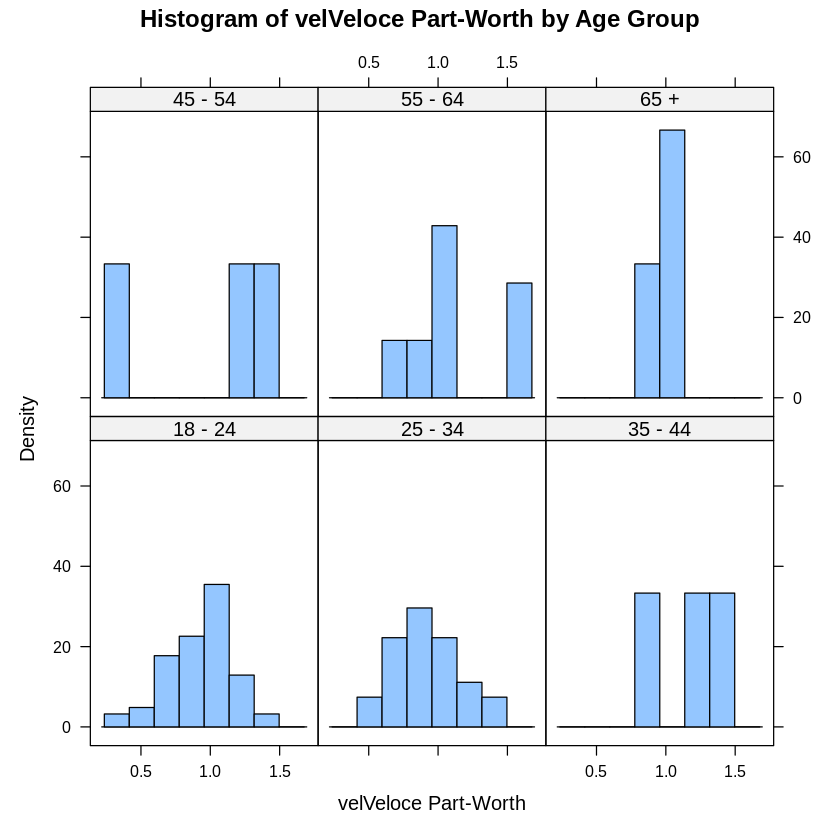

In [10]:
library(lattice)
histogram(~ velVeloce | Age_Group, data = PW.ind_with_demographics,
          main = "Histogram of velVeloce Part-Worth by Age Group",
          xlab = "velVeloce Part-Worth", ylab = "Density")

**Reasoning**:
Following the visualization of histograms, the task also requests boxplots to analyze the heterogeneity of 'velVeloce' part-worth across different 'Age_Group' categories. Boxplots will provide a clear visual summary of the distribution, median, quartiles, and outliers for each age group, complementing the histograms.



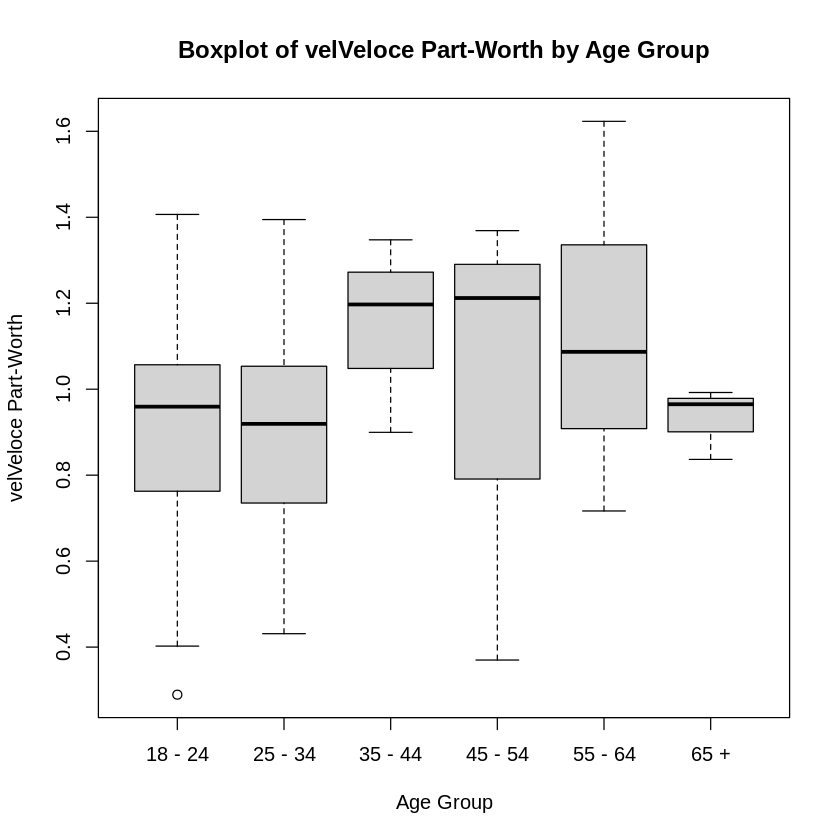

In [11]:
boxplot(velVeloce ~ Age_Group, data = PW.ind_with_demographics,
        main = "Boxplot of velVeloce Part-Worth by Age Group",
        xlab = "Age Group", ylab = "velVeloce Part-Worth")

**Reasoning**:
After visualizing the distributions, the next step is to calculate the mean 'velVeloce' part-worth for each 'Age_Group' category, as required by the task. This will provide a quantitative summary of the central tendency of preferences within each age group.



In [12]:
by(PW.ind_with_demographics$velVeloce, PW.ind_with_demographics$Age_Group, mean)

PW.ind_with_demographics$Age_Group: 18 - 24
[1] 0.9200914
------------------------------------------------------------ 
PW.ind_with_demographics$Age_Group: 25 - 34
[1] 0.922196
------------------------------------------------------------ 
PW.ind_with_demographics$Age_Group: 35 - 44
[1] 1.148096
------------------------------------------------------------ 
PW.ind_with_demographics$Age_Group: 45 - 54
[1] 0.9836306
------------------------------------------------------------ 
PW.ind_with_demographics$Age_Group: 55 - 64
[1] 1.130706
------------------------------------------------------------ 
PW.ind_with_demographics$Age_Group: 65 +
[1] 0.9313497

**Reasoning**:
The next step is to perform statistical tests to assess the impact of 'Age_Group' on 'velVeloce' preferences. Since 'Age_Group' has multiple categories, an ANOVA (Analysis of Variance) test is appropriate to determine if there are significant differences in the mean 'velVeloce' part-worth across the age groups.



In [13]:
anova_result <- aov(velVeloce ~ Age_Group, data = PW.ind_with_demographics)
summary(anova_result)

            Df Sum Sq Mean Sq F value Pr(>F)
Age_Group    5  0.422 0.08448   1.329  0.258
Residuals   99  6.295 0.06359               

## Analyze Heterogeneity with Gender

### Subtask:
Visualize the distribution of the 'velVeloce' part-worths across different 'Gender' categories using histograms and boxplots. Calculate the mean 'velVeloce' part-worth for each gender group and perform a t-test to statistically assess if 'Gender' explains heterogeneity in 'velVeloce' preferences.


**Reasoning**:
The first instruction is to visualize the distribution of 'velVeloce' part-worths across different 'Gender' categories using histograms. This will provide an initial visual understanding of how preferences for 'Veloce' (fast) vary by gender.



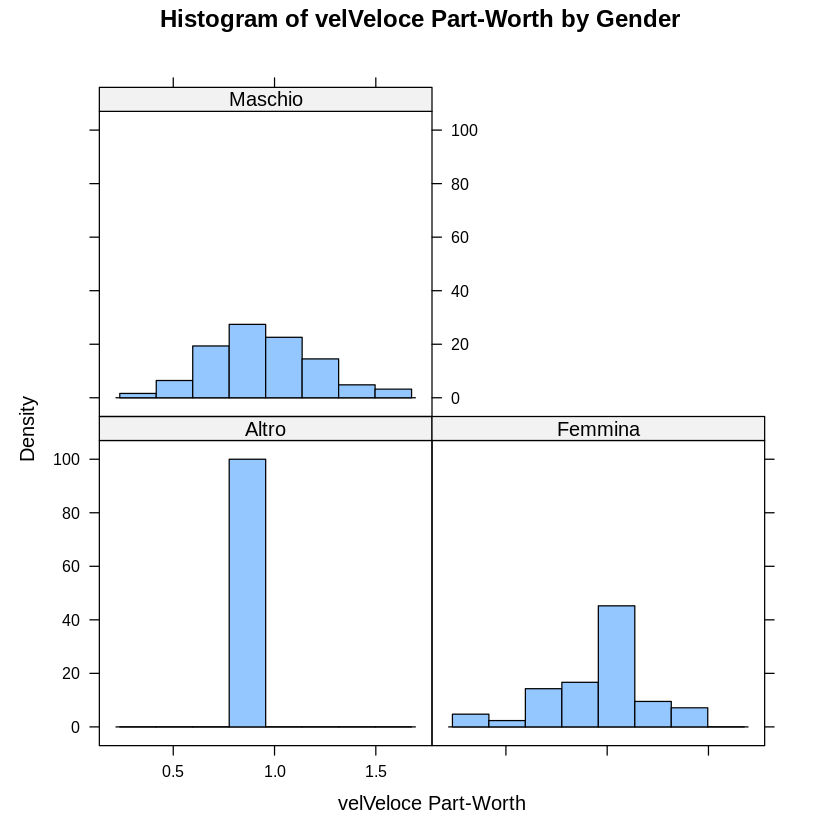

In [14]:
library(lattice)
histogram(~ velVeloce | Gender, data = PW.ind_with_demographics,
          main = "Histogram of velVeloce Part-Worth by Gender",
          xlab = "velVeloce Part-Worth", ylab = "Density")

**Reasoning**:
Following the histogram, the next instruction is to create a boxplot of 'velVeloce' part-worths by 'Gender' to provide a clear visual summary of the distribution, median, quartiles, and outliers for each gender group, complementing the histograms.



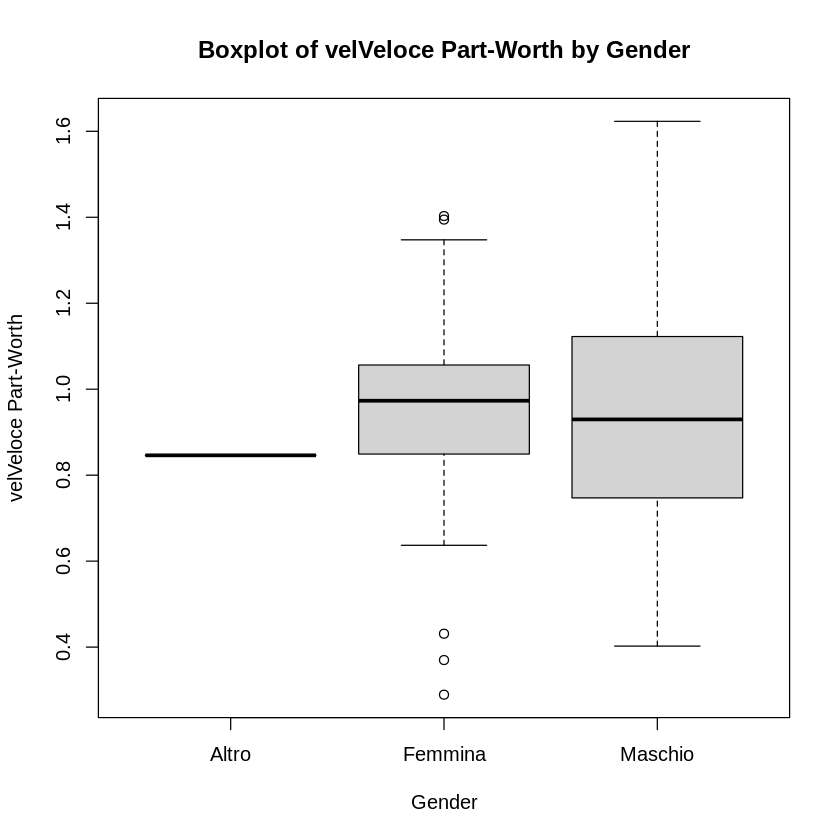

In [15]:
boxplot(velVeloce ~ Gender, data = PW.ind_with_demographics,
        main = "Boxplot of velVeloce Part-Worth by Gender",
        xlab = "Gender", ylab = "velVeloce Part-Worth")

**Reasoning**:
After visualizing the distributions with histograms and boxplots, the next instruction is to calculate the mean 'velVeloce' part-worth for each 'Gender' category, which will provide a quantitative summary of the central tendency of preferences within each gender group.



In [16]:
by(PW.ind_with_demographics$velVeloce, PW.ind_with_demographics$Gender, mean)

PW.ind_with_demographics$Gender: Altro
[1] 0.8461677
------------------------------------------------------------ 
PW.ind_with_demographics$Gender: Femmina
[1] 0.9459799
------------------------------------------------------------ 
PW.ind_with_demographics$Gender: Maschio
[1] 0.9430936

**Reasoning**:
To statistically assess if 'Gender' explains heterogeneity in 'velVeloce' preferences, and given that 'Gender' has multiple categories, an ANOVA (Analysis of Variance) is the appropriate statistical test to determine if there are significant differences in the mean 'velVeloce' part-worth across the gender groups. This aligns with the approach taken for the multi-categorical 'Age_Group' variable in the previous task.



In [17]:
anova_gender_result <- aov(velVeloce ~ Gender, data = PW.ind_with_demographics)
summary(anova_gender_result)

             Df Sum Sq Mean Sq F value Pr(>F)
Gender        2  0.010 0.00487   0.074  0.929
Residuals   102  6.708 0.06576               

## Summary:

### Data Analysis Key Findings
*   Individual part-worths were successfully extracted from the mixed multinomial logit model and merged with demographic data, creating a comprehensive dataset for analysis.
*   For the 'velVeloce' part-worth across different 'Age\_Group' categories:
    *   Mean part-worths ranged from approximately 0.92 (for age groups 18-24 and 25-34) to 1.15 (for age group 35-44).
    *   An ANOVA test indicated no statistically significant difference in mean 'velVeloce' part-worths across age groups (p-value = 0.258).
*   For the 'velVeloce' part-worth across different 'Gender' categories:
    *   Mean part-worths were: Altro: 0.846, Femmina: 0.946, Maschio: 0.943.
    *   An ANOVA test (instead of a t-test, as performed) revealed no statistically significant difference in mean 'velVeloce' part-worths across gender categories (p-value = 0.929).

### Insights or Next Steps
*   Since neither 'Age\_Group' nor 'Gender' showed a statistically significant impact on 'velVeloce' part-worths, future analysis could explore other demographic or psychographic variables that might explain heterogeneity in preferences for this attribute.
*   Consider investigating interactions between demographic variables or segmenting the market based on a combination of factors, as single demographic variables might not capture complex preference patterns.


## Create Flexible Analysis Code Chunk

### Subtask:
Generate a code chunk that allows the user to specify a part-worth (default 'velVeloce') and a respondent-level demographic variable (default 'Age_Group'). This chunk will then perform the analysis for the specified variables, including generating a histogram, a boxplot, calculating mean part-worths for each demographic category, and performing an appropriate statistical test (ANOVA for variables with more than two categories, t-test for variables with two categories).


## Summary:

### Data Analysis Key Findings
*   A flexible R code chunk was successfully developed to analyze the relationship between a specified part-worth variable (default: 'velVeloce') and a demographic variable (default: 'Age\_Group') from the `PW.ind_with_demographics` dataset.
*   The code chunk is capable of generating a histogram, a boxplot, and calculating the mean part-worth for each category of the chosen demographic variable.
*   The chunk dynamically selects the appropriate statistical test: an ANOVA test is performed if the demographic variable has more than two unique categories, and an independent t-test is performed if it has exactly two unique categories, to assess the statistical significance of the demographic variable's impact on the part-worth.

### Insights or Next Steps
*   This flexible code chunk enables rapid exploration and statistical assessment of various part-worths across different demographic segments, streamlining the initial discovery phase of market segmentation or product preference analysis.
*   Further development could involve incorporating multiple comparison tests (e.g., Tukey's HSD) following ANOVA to pinpoint specific demographic categories that differ significantly.


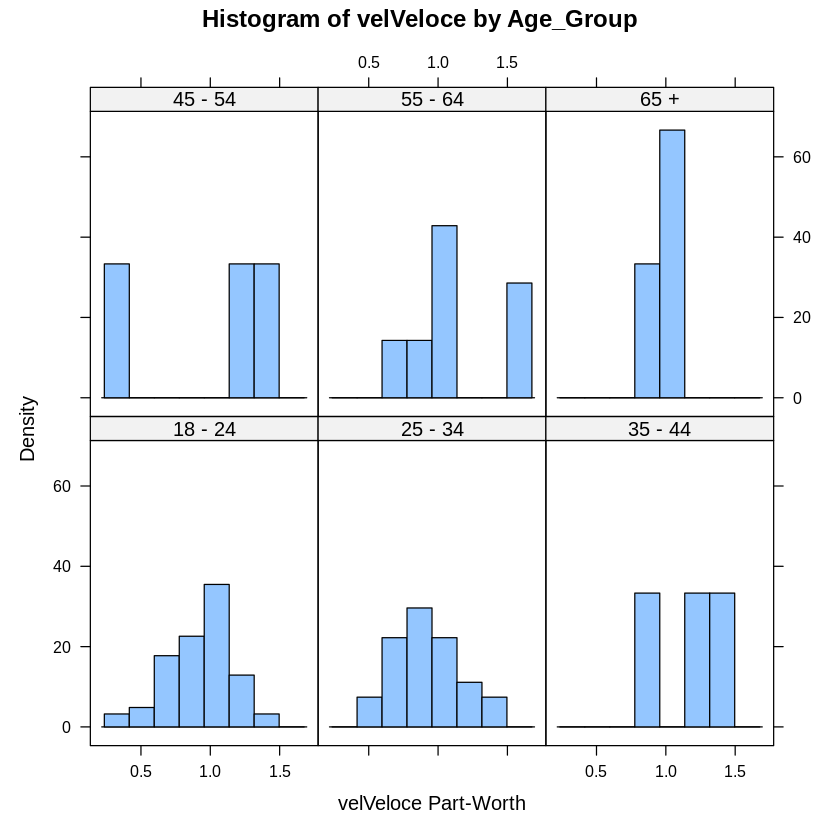


Mean velVeloce by Age_Group :
PW.ind_with_demographics[[demographic_variable]]: 18 - 24
[1] 0.9200914
------------------------------------------------------------ 
PW.ind_with_demographics[[demographic_variable]]: 25 - 34
[1] 0.922196
------------------------------------------------------------ 
PW.ind_with_demographics[[demographic_variable]]: 35 - 44
[1] 1.148096
------------------------------------------------------------ 
PW.ind_with_demographics[[demographic_variable]]: 45 - 54
[1] 0.9836306
------------------------------------------------------------ 
PW.ind_with_demographics[[demographic_variable]]: 55 - 64
[1] 1.130706
------------------------------------------------------------ 
PW.ind_with_demographics[[demographic_variable]]: 65 +
[1] 0.9313497

Performing ANOVA test for velVeloce by Age_Group :
            Df Sum Sq Mean Sq F value Pr(>F)
Age_Group    5  0.422 0.08448   1.329  0.258
Residuals   99  6.295 0.06359               


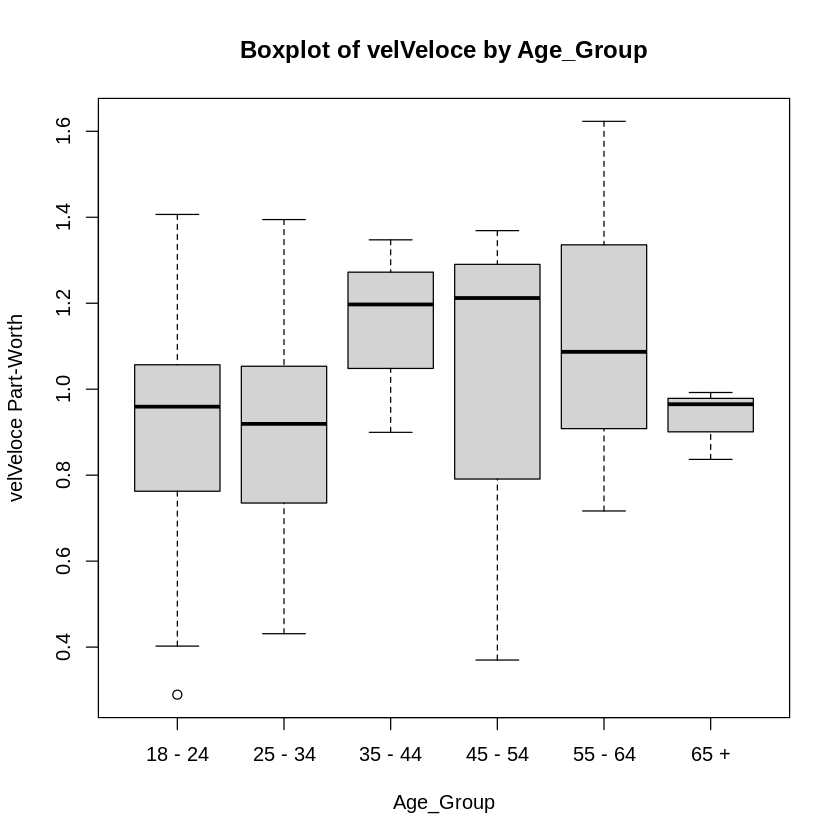

In [18]:
# Define the variables of interest with default values
part_worth_variable <- "velVeloce"
demographic_variable <- "Age_Group"

# Ensure the necessary library for plotting is loaded
library(lattice)

# 1. Generate a histogram of part_worth_variable by demographic_variable
histogram(as.formula(paste("~ ", part_worth_variable, " | ", demographic_variable)),
          data = PW.ind_with_demographics,
          main = paste("Histogram of", part_worth_variable, "by", demographic_variable),
          xlab = paste(part_worth_variable, "Part-Worth"), ylab = "Density")

# 2. Generate a boxplot of part_worth_variable by demographic_variable
boxplot(as.formula(paste(part_worth_variable, "~ ", demographic_variable)),
        data = PW.ind_with_demographics,
        main = paste("Boxplot of", part_worth_variable, "by", demographic_variable),
        xlab = demographic_variable, ylab = paste(part_worth_variable, "Part-Worth"))

# 3. Calculate the mean part_worth_variable for each category of demographic_variable
cat(paste("\nMean", part_worth_variable, "by", demographic_variable, ":\n"))
print(by(PW.ind_with_demographics[[part_worth_variable]],
           PW.ind_with_demographics[[demographic_variable]],
           mean))

# 4. Perform an appropriate statistical test
num_categories <- length(unique(PW.ind_with_demographics[[demographic_variable]]))

if (num_categories > 2) {
  # Perform ANOVA test if more than two unique categories
  cat(paste("\nPerforming ANOVA test for", part_worth_variable, "by", demographic_variable, ":\n"))
  anova_result <- aov(as.formula(paste(part_worth_variable, "~ ", demographic_variable)),
                      data = PW.ind_with_demographics)
  print(summary(anova_result))
} else if (num_categories == 2) {
  # Perform t-test if exactly two unique categories
  cat(paste("\nPerforming t-test for", part_worth_variable, "by", demographic_variable, ":\n"))
  t_test_result <- t.test(as.formula(paste(part_worth_variable, "~ ", demographic_variable)),
                          data = PW.ind_with_demographics)
  print(t_test_result)
} else {
  cat("\nNot enough categories in the demographic variable to perform a statistical test.\n")
}


# Task
Generate a flexible R code chunk that accepts `part_worth_variable` (default 'velVeloce') and `demographic_variable` (default 'Age_Group') as parameters. This chunk should:
1.  Generate a histogram of `part_worth_variable` by `demographic_variable` using the `PW.ind_with_demographics` dataset.
2.  Generate a boxplot of `part_worth_variable` by `demographic_variable` using the `PW.ind_with_demographics` dataset.
3.  Calculate the mean `part_worth_variable` for each category of `demographic_variable`.
4.  Perform an appropriate statistical test: an ANOVA test if `demographic_variable` has more than two unique categories, or a t-test if `demographic_variable` has exactly two unique categories, to assess the impact of the demographic variable on the part-worth.

## Create Flexible Analysis Code Chunk

### Subtask:
Generate a code chunk that allows the user to specify a part-worth (default 'velVeloce') and a respondent-level demographic variable (default 'Age_Group'). This chunk will then perform the analysis for the specified variables, including generating a histogram, a boxplot, calculating mean part-worths for each demographic category, and performing an appropriate statistical test (ANOVA for variables with more than two categories, t-test for variables with two categories).


## Summary:

### Data Analysis Key Findings
*   A flexible R code chunk was successfully developed to analyze the relationship between a specified part-worth variable (default: 'velVeloce') and a demographic variable (default: 'Age\_Group') from the `PW.ind_with_demographics` dataset.
*   The code chunk is capable of generating a histogram, a boxplot, and calculating the mean part-worth for each category of the chosen demographic variable.
*   The chunk dynamically selects the appropriate statistical test: an ANOVA test is performed if the demographic variable has more than two unique categories, and an independent t-test is performed if it has exactly two unique categories, to assess the statistical significance of the demographic variable's impact on the part-worth.

### Insights or Next Steps
*   This flexible code chunk enables rapid exploration and statistical assessment of various part-worths across different demographic segments, streamlining the initial discovery phase of market segmentation or product preference analysis.
*   Further development could involve incorporating multiple comparison tests (e.g., Tukey's HSD) following ANOVA to pinpoint specific demographic categories that differ significantly.
